# Introduction to Image Processing

Notebook originally made by **Suhas Somnath**<br>
National Center for Computational Sciences<br>
Oak Ridge National Laboratory

## Popular packages:
* [scikit-image](https://scikit-image.org/) a.k.a ``skimage`` - comes with Anaconda
* [Open CV for python](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html) a.k.a ``cv2`` - requires Conda installation

There is a significant overlap between the two packages and we will be demonstrating ``skimage`` below

### Load necessary packages:

In [2]:
# Numeric operations
import numpy as np
# Visualization / Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
# Scientific image processing library:
import skimage
if int(skimage.__version__.split('.')[1]) < 14:
    from warnings import warn
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version'.format(skimage.__version__))
from skimage import io
from skimage import filters
from skimage.morphology import disk
from skimage.feature import blob_log
from skimage import data
from skimage import measure
from skimage.filters import threshold_mean, threshold_isodata, threshold_minimum, threshold_otsu, threshold_triangle, threshold_li

from skimage import exposure

# Ensure that images are rendered in this notebook:
%matplotlib inline

## Reading images
The most popular method to read images is using the ``skimage.io.imread()`` function

In [ ]:
# Download the image we will work with

%%shell

gdown https://drive.google.com/uc?id=1PK_jZQInvF24zd32mHOczhWLrpLrXX4f

In [4]:
# Reading the image here:
stem_image = io.imread('LLTO_800.tif')

## Images are just matrices of numbers:

In [5]:
print('Image read as: {}'.format(type(stem_image)))
print('Image of shape: {} and precision: {}'.format(stem_image.shape, stem_image.dtype))

Image read as: <class 'numpy.ndarray'>
Image of shape: (512, 512) and precision: uint16


In other words, the image has 512 rows and 512 columns.

Let's take a look at the contents of a single pixel:

In [6]:
stem_image[5, 4]

16672

## Visualizing images:
We will be using matplotlib for simplicity

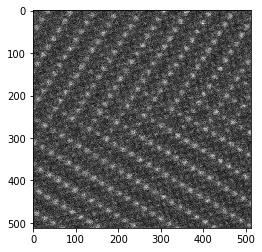

In [7]:
fig, axis = plt.subplots()
axis.imshow(stem_image, cmap='gray');

## Normalizing images

``skimage.img_as_float`` is a very handy function that is often used to normalize the data to ``[0, 1]`` from the original datatype

In [8]:
print('Before normalization: data type: {}, Min: {}, max: {}'.format(stem_image.dtype, stem_image.min(), stem_image.max()))

# Normalizing here:
stem_image = skimage.img_as_float(stem_image)

print('After normalization: data type: {}, Min: {}, max: {}'.format(stem_image.dtype, stem_image.min(), stem_image.max()))

Before normalization: data type: uint16, Min: 2010, max: 59821
After normalization: data type: float64, Min: 0.030670634012359806, max: 0.9128099488822766


### Image manipulation

Since images are just arrays of numbers, we can manipulat them easily just as we would any array:

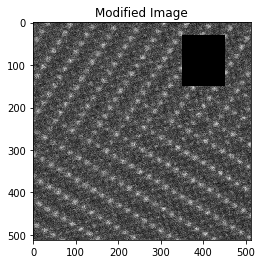

In [9]:
modified_image = stem_image.copy()

# Let's set a rectangle within the image to some new value:
modified_image[30:150, 350:450] = 0

# Visualize the modified image
fig, axis = plt.subplots()
axis.imshow(modified_image, cmap='gray')
axis.set_title('Modified Image');

### Cropping images:
Images are cropped in the same way that numpy arrays are sliced

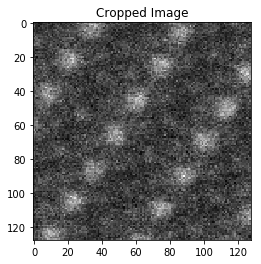

In [10]:
cropped_image = stem_image[:128, :128]

fig, axis = plt.subplots()
axis.imshow(cropped_image, cmap='gray')
axis.set_title('Cropped Image');

### Pseudo-color or false-color:
A color scheme can be applied to grayscale images  by mapping each grayscale intensity value to a color if desired using the ``cmap`` keyword of ``matplotlib.pyplot.imshow()``:

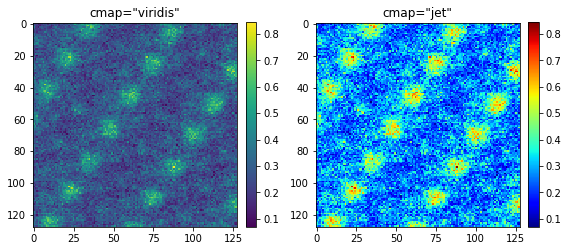

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
# Viridis is assigned by default even if the cmap argument is not specified
im_handle = axes[0].imshow(cropped_image)
axes[0].set_title('cmap="viridis"')
# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axes[0], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)

im_handle = axes[1].imshow(cropped_image, cmap='jet')
axes[1].set_title('cmap="jet"')
# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axes[1], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)
fig.tight_layout()

## Channels

Black and white images have a single **channel** of information while color images have three (red, green, blue) channels of information.

Thus a ``512``x``512`` pixel color image would be represented as a ``(512, 512, 3)`` array

Image shape: (300, 451, 3)


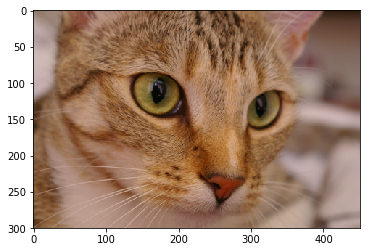

In [12]:
# Loading the built-in example dataset from scikit image:
cat = data.chelsea()

print("Image shape:", cat.shape)

fig, axis = plt.subplots()
axis.imshow(cat);

#### Visualizing the three channels separately:

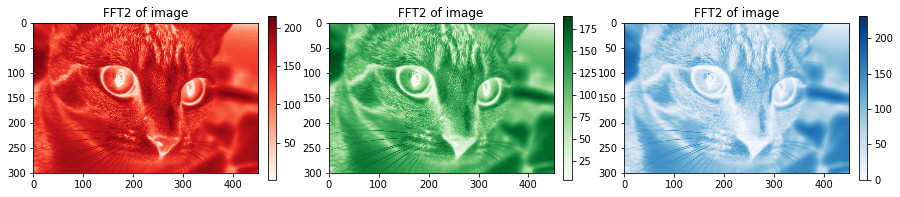

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 3))
for chan, axis, colmap, title in zip(range(cat.shape[2]), 
                                     axes.flat, 
                                     [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues],
                                     ['Red', 'Green', 'Blue']):
    im_handle = axis.imshow(np.squeeze(cat[:, :, chan]), cmap=colmap)
    axis.set_title(title)
    
    cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
    axis.set_title('FFT2 of image');

### Converting color images to grayscale:

``skimage`` has a very handy function just for this - ``color.rgb2gray()``:

Original shape: (300, 451, 3), grayscale shape: (300, 451)


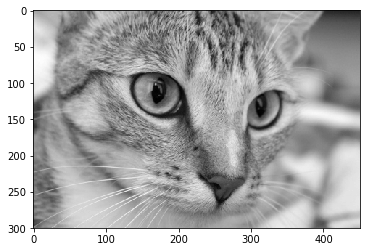

In [14]:
gscale_cat = skimage.color.rgb2gray(cat)
print('Original shape: {}, grayscale shape: {}'.format(cat.shape, gscale_cat.shape))

fig, axis = plt.subplots()
axis.imshow(gscale_cat, cmap='gray');

## Shapes of images when loaded into Python:

From [Stefan Van der Walt's tutorial](https://github.com/stefanv/imagexd_scientific_python/blob/master/images_are_arrays.ipynb)

|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

## Frequency space
A lot of information cam be gained by visualizing the same image in the frequency domain:

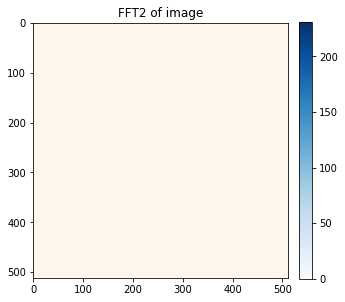

In [15]:
fft_image_raw = np.fft.fft2(stem_image)

fig, axis = plt.subplots(figsize=(5, 5))
# Visualize the magnitude only:
im_hande = axis.imshow(np.abs(fft_image_raw), cmap=plt.cm.OrRd)
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT2 of image');

Not much is visible just by taking the 2D FFT. Let's try looking at the ``log`` of the FFT:

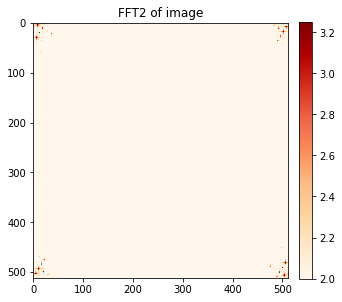

In [16]:
fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw)), 
                        cmap=plt.cm.OrRd, vmin=2, vmax=3.25)
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT2 of image');

Plotting the magnitude 2D-FFT on a vertical log scales shows something unexpected: there appears to be peaks at the corners and no information at the center. This is because the output for the ``fft2`` function flips the frequency axes so that low frequencies are at the ends, and the highest frequency is in the middle.

### Correcting the FFT

To correct this, use the ``fftshift`` command. fftshift brings the lowest frequency components of the FFT back to the center of the plot

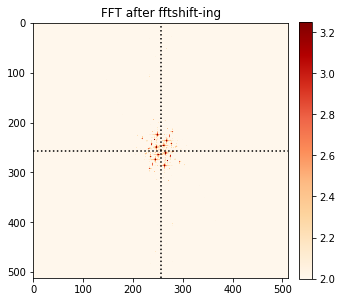

In [17]:
fft_image_raw_shifted = np.fft.fftshift(fft_image_raw)

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw_shifted)), 
                        cmap=plt.cm.OrRd, vmin=2, vmax=3.25)
axis.axvline(x=fft_image_raw_shifted.shape[0] // 2, color='k', linestyle=':')
axis.axhline(y=fft_image_raw_shifted.shape[1]// 2, color='k', linestyle=':')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT after fftshift-ing');

## Image filters
The atomically resolved image above appears to be quite noisy and the atomic columns are not clearly visible. Let's apply some image filters to see what they do to the image:

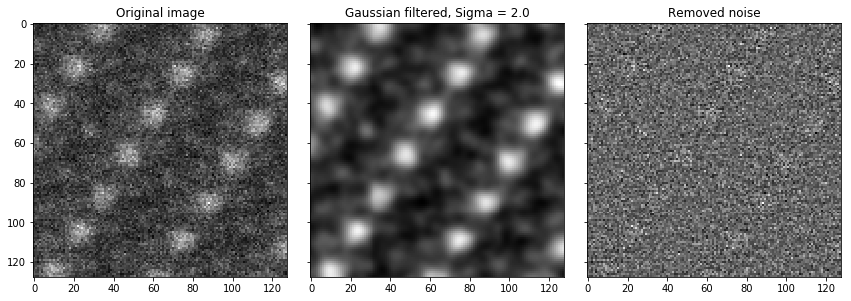

In [18]:
cropped_image = stem_image[:128, :128]

gaus_sigma = 2.0

gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
axes[0].imshow(cropped_image, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(gaussian_filtered, cmap='gray')
axes[1].set_title('Gaussian filtered, Sigma = {}'.format(gaus_sigma))
axes[2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[2].set_title('Removed noise');
fig.tight_layout()

### Visualize the effect of filtering in the frequency domain:
The center of the image (low-frequency) remains more-or-less the same but the data outside the center (higher spatial frequencies) is drastically reduced in magnitude thereby resulting in a cleaner image. All the noise from the higher frequencies is visible in the removed noise

Thus, the Gaussian filter is essentially a low-pass filter

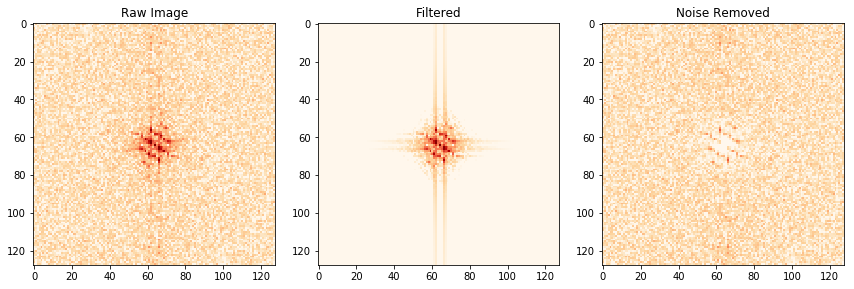

In [19]:
fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_noise_rem = np.fft.fftshift(np.fft.fft2(cropped_image - gaussian_filtered))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for axis, fft_img, title in zip(axes.flat, 
                                [fft_raw, fft_gaus_filt, fft_noise_rem],
                                ['Raw Image', 'Filtered', 'Noise Removed']):
    axis.imshow(np.log10(np.abs(fft_img)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axis.set_title(title)
fig.tight_layout()

## Trying different filter parameters:
In the case of the gaussian filter, one can try differetn values of the standard deviation for the Gaussian kernel via the ``sigma`` keyword argument. 

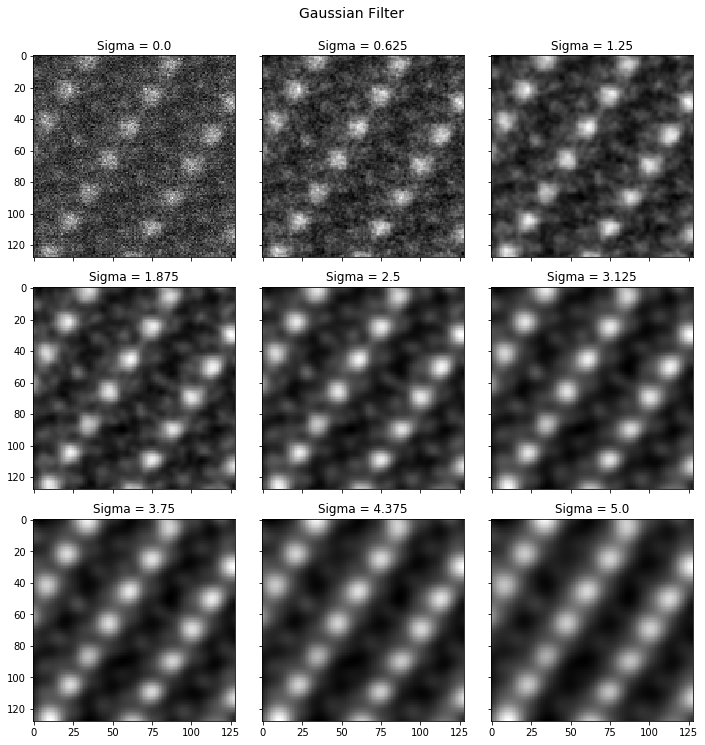

In [20]:
cropped_image = stem_image[:128, :128]

sigma_values = np.linspace(0, 5, num=9)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True)
for axis, gaus_sigma in zip(axes.flat, sigma_values):
    gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
    axis.imshow(gaussian_filtered, cmap='gray')
    axis.set_title('Sigma = {}'.format(gaus_sigma));
fig.suptitle('Gaussian Filter', fontsize=14, y=1.03)
fig.tight_layout()

## Exercises
How well can you filter the STEM image? Can you make the duller / lower atomic columns clearer?

## More filters:
Several more filters are available in skimage. We will only try out a handful below:
* [Local mean](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Median](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Gaussian](https://www.scipy-lectures.org/packages/scikit-image/#mathematical-morphology)
* [Unsupervised Wiener](http://scikit-image.org/docs/dev/auto_examples/filters/plot_restoration.html)
* [Bi-lateral Mean](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Wiener deconvolution](http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.wiener)

C:\Users\Suhas\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Suhas\Anaconda3\lib\site-packages\skimage\restoration\uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


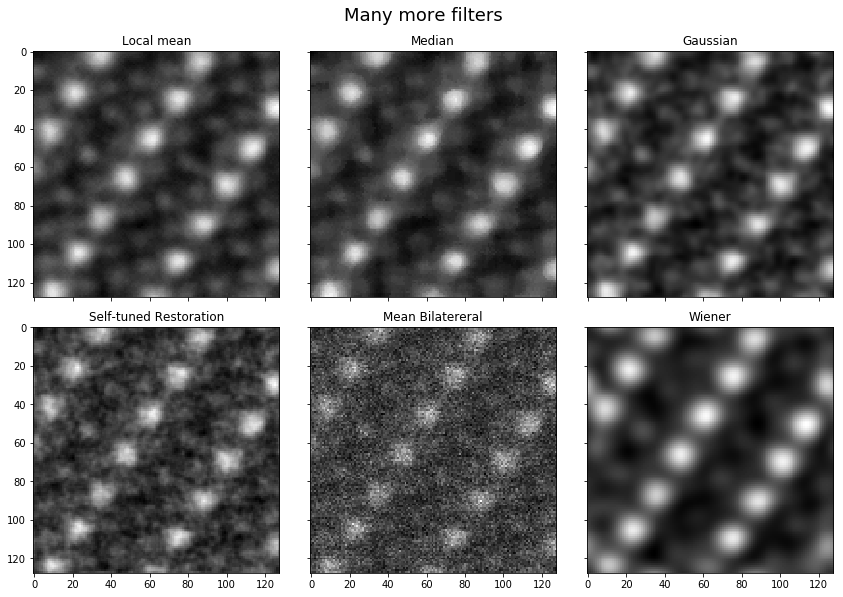

In [18]:
cropped_image = stem_image[:128, :128]

# Local mean filter
loc_mean = filters.rank.mean(cropped_image, disk(4))

# Median filter:
median_filtered = filters.median(cropped_image, disk(5))

# Gaussian Filter
gaussian_filtered = filters.gaussian(cropped_image, sigma=1.875)

# Bilateral mean
noisy_image = skimage.img_as_ubyte(cropped_image)
bilat_filtered = filters.rank.mean_bilateral(noisy_image.astype(np.uint16), disk(10), s0=5, s1=5)

# Self-tuned Wiener
disk_size = int(1)
psf = np.ones((disk_size, disk_size)) / disk_size**2
self_tuned, _ = skimage.restoration.unsupervised_wiener(cropped_image, psf)

# Wiener deconvolution
disk_size = int(10)
psf = np.ones((disk_size, disk_size)) / disk_size**2
wiener_filtered = skimage.restoration.wiener(cropped_image, psf, 50)

# Visualizing results here:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8),
                         sharex=True, sharey=True)
for axis, img, title in zip(axes.flat, 
                            [loc_mean, median_filtered, gaussian_filtered, 
                             self_tuned, bilat_filtered, wiener_filtered],
                            ['Local mean', 'Median', 'Gaussian', 
                             'Self-tuned Restoration', 'Mean Bilatereral', 'Wiener']):
    axis.imshow(img, cmap='gray')
    axis.set_title(title)
fig.suptitle('Many more filters', fontsize=18, y=1.03)
fig.tight_layout()

### Exercises:
As mentioned above, most filters require manipulation of filter parameters. See if you can improve the filters by varying the filter parameters:

## Switching images here:

To better illustrate edge sensitive algorithms, let's switch to a different image:

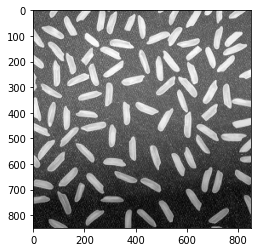

In [21]:
rice_image = io.imread('https://www.mathworks.com/content/mathworks/www/en/company/newsletters/articles/new-features-for-high-performance-image-processing-in-matlab/jcr:content/mainParsys/image_1.adapt.full.high.jpg/1469941471626.jpg')

# Convert to float: Important for subtraction later which won't work with uint8
rice_image = skimage.img_as_float(skimage.color.rgb2gray(rice_image))

fig, axis = plt.subplots()
axis.imshow(rice_image, cmap='gray');

## [Edge detection](http://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html)

Useful for: 
* detecting discontinuities in material properties
* detecting discontinuities in orientation
* compressing amount of information and simplifying computations (conversion to binary)

Few popular filters:
* Sobel
* Scharr
* Roberts
* Prewitt

They are also applied in the same way as the Mean, Median, Gaussian ... filters above

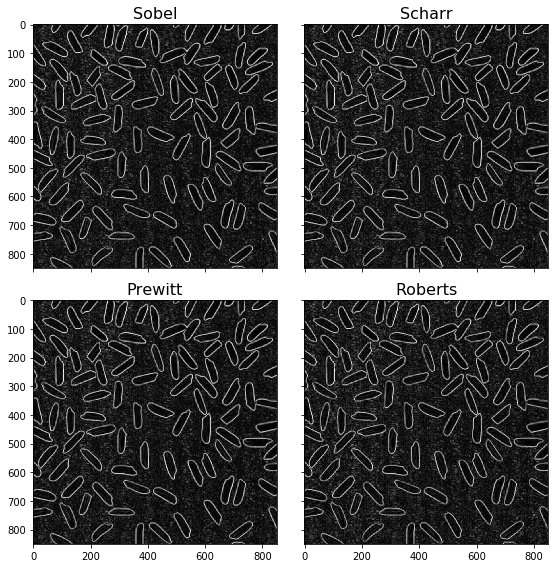

In [22]:
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=2, 
                         sharex=True, sharey=True)
for axis, filt_alg, title in zip(axes.flat, 
                                 [filters.sobel, filters.scharr,
                                  filters.prewitt, filters.roberts],
                                 ['Sobel', 'Scharr', 'Prewitt', 'Roberts']):
    axis.imshow(filt_alg(rice_image), cmap='gray')
    axis.set_title(title, fontsize=16)
fig.tight_layout()

Let's take the result from the ``Prewitt`` filter and convert it to a binary image

We will do this in three stages:
* Apply the filter to the raw image
* Normalize the data to lie within [0, 1]
* Threshold the data

In [23]:
# Step 1: Apply the filter:
prewitt_bin = filters.prewitt(rice_image)

# Step 2: Let's normalize this data to [0, 1]
prewitt_bin = prewitt_bin - prewitt_bin.min()
prewitt_bin = prewitt_bin / prewitt_bin.max()
print('Min: {}, max: {}'.format(prewitt_bin.min(), prewitt_bin.max()))

Min: 0.0, max: 1.0


Let's plot the histogram of the normalized image to guide us in picking a sensible value to threshold the image in the next step

Text(0.5, 0, 'Pixel intensity')

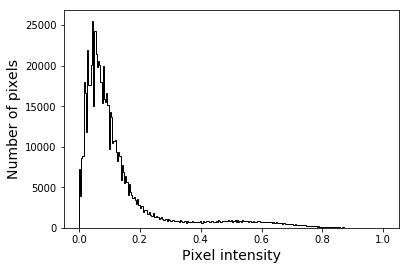

In [24]:
fig, axis = plt.subplots()
axis.hist(prewitt_bin.ravel(), bins=256, histtype='step', color='black');
axis.set_ylabel('Number of pixels', fontsize=14)
axis.set_xlabel('Pixel intensity', fontsize=14)

Finally, pick a reasonable value to threshold with. Set all values below the threshold to 0 and all values above to 1

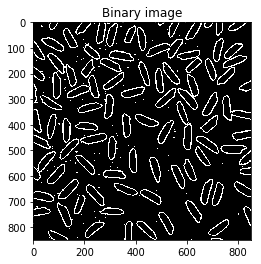

In [25]:
threshold = 0.3
prewitt_bin[prewitt_bin > threshold] = 1
prewitt_bin[prewitt_bin <= threshold] = 0

fig, axis = plt.subplots()
axis.set_title('Binary image')
axis.imshow(prewitt_bin, cmap='gray');

### Directional Edge filters

``skimage`` also has a few filters that will only pick up vertical or horizontal edges only. 

Let's try the two anisotropic ``Sobel`` filters:

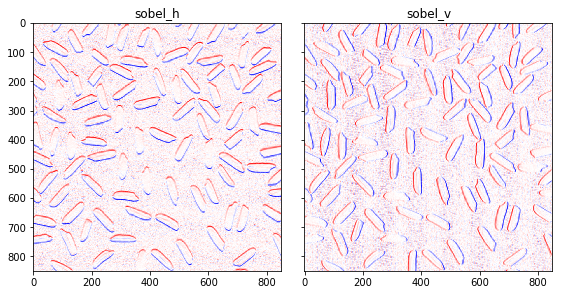

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)
for axis, algo in zip(axes.flat, [filters.sobel_h, filters.sobel_v]):
    filtered_image = algo(rice_image)
    axis.imshow(filtered_image, cmap='bwr')
    axis.set_title(algo.__name__)
fig.tight_layout()

## [Thresholding](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

In certain cases, we may may be working on images that have two distinct phases, kinds of objects, heights, etc. **that appear different to a reasonable extent** (like the rice image) and we may want to apply separate processing steps on each part of the image.

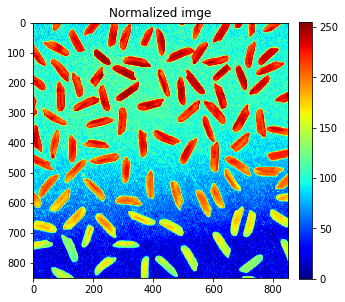

In [27]:
# Normalizing to [0, 255]
rice_renormalized = rice_image - rice_image.min()
rice_renormalized = 255 * rice_renormalized / rice_renormalized.max()

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(rice_renormalized, cmap='jet')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('Normalized imge');

``skimage`` has plenty of algorithms that simplify the separation of the two phases via ``thresholding``.

There are two steps to creating the binary image with the two phases:
* Calculate the thresholding value
* Find all pixels in the original image greater than the threshold

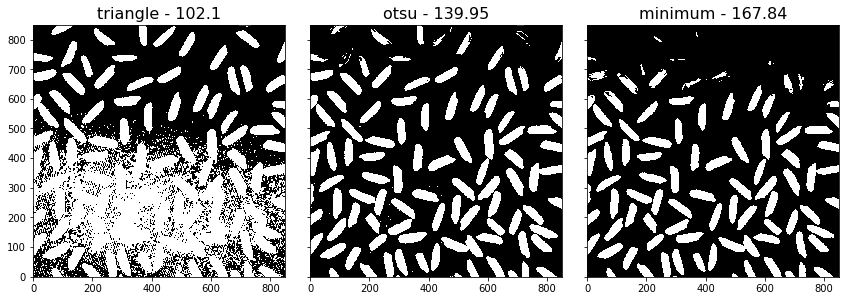

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

for axis, algo in zip(axes.flat, 
                      # These are three algorithms we will try:
                      [threshold_triangle, threshold_otsu, threshold_minimum]):
    
    # First calculate the threshold value
    thresh = algo(rice_renormalized)
    
    # Find all pixels whose intensity is greater than the threshold
    binary_img = rice_renormalized > thresh
    
    axis.imshow(binary_img, cmap='gray', origin='lower')
    algo_name = algo.__name__.split('_')[1]
    axis.set_title('{} - {}'.format(algo_name, np.round(thresh, 2)), fontsize=16)
    
fig.tight_layout()

## [Background subtraction](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html):
From the images above, it appears that the long-range features / background intensity is making it challenging to perform local operations such as thresholding. 

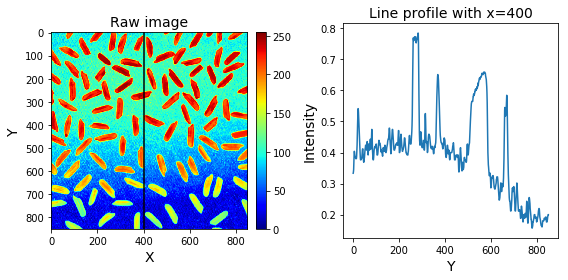

In [29]:
section_x = 400

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
im_handle = axes[0].imshow(rice_renormalized, cmap='jet')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axes[0], fraction=0.046, pad=0.04)
axis.set_title('Normalized imge');
axes[0].axvline(x=section_x, color='k')
axes[0].set_title('Raw image', fontsize=14)
axes[0].set_xlabel('X', fontsize=14)
axes[0].set_ylabel('Y', fontsize=14)

axes[1].plot(np.squeeze(rice_image[:, section_x]));
axes[1].set_title('Line profile with x={}'.format(section_x), fontsize=14)
axes[1].set_xlabel('Y', fontsize=14)
axes[1].set_ylabel('Intensity', fontsize=14)
fig.tight_layout();

Here we will try to remove the background image

In [30]:
x_pixels, y_pixels = rice_image.shape  # [pixels]
x_edge_length = 5.0  # [nm]
y_edge_length = 5.0  # [nm]
x_sampling = x_pixels / x_edge_length  # [pixels/nm]
y_sampling = y_pixels / y_edge_length  # [pixels/nm]
x_axis_vec = np.linspace(-x_edge_length / 2, x_edge_length / 2, x_pixels)  # vector of locations along x-axis
y_axis_vec = np.linspace(-y_edge_length / 2, y_edge_length / 2, y_pixels)  # vector of locations along y-axis
x_mat, y_mat = np.meshgrid(x_axis_vec, y_axis_vec)  # matrices of x-positions and y-positions

u_max = x_sampling / 2
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max / 2, u_max / 2, x_pixels)
v_axis_vec = np.linspace(-v_max / 2, v_max / 2, y_pixels)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec)  # matrices of u-positions and v-positions
r = np.sqrt(u_mat**2+v_mat**2) # convert cartesian coordinates to polar radius

#### Create the filter:

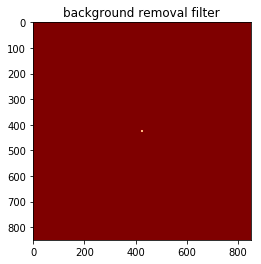

In [31]:
# inverse width of gaussian, units same as real space axes
filter_width = 3.5

inverse_gauss_filter = 1-np.e**(-(r*filter_width)**2)

fig, axis = plt.subplots()
axis.imshow(inverse_gauss_filter, cmap=plt.cm.OrRd)
axis.set_title('background removal filter');

#### Apply the filter to the raw image

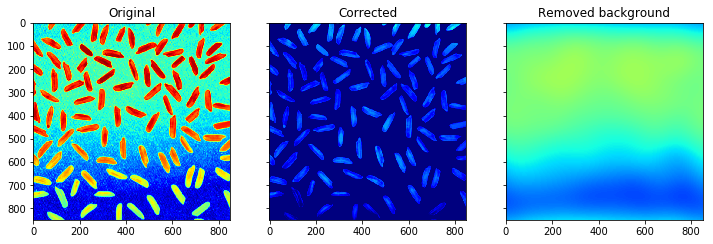

In [32]:
# take the fft of the image
fft_image_w_background = np.fft.fftshift(np.fft.fft2(rice_image))
fft_abs_image_background = np.abs(fft_image_w_background)

# apply the filter
fft_image_corrected = fft_image_w_background * inverse_gauss_filter

# perform the inverse fourier transform on the filtered data
image_corrected = np.real(np.fft.ifft2(np.fft.ifftshift(fft_image_corrected)))

# find what was removed from the image by filtering
filtered_background = rice_image - image_corrected

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
for axis,img, title in zip(axes.flat, 
                           [rice_image, image_corrected, filtered_background],
                           ['Original', 'Corrected', 'Removed background']):
    axis.imshow(img, cmap='jet', vmin=rice_image.min(), vmax=rice_image.max())
    axis.set_title(title)

#### Renormalizing the background-corrected data:

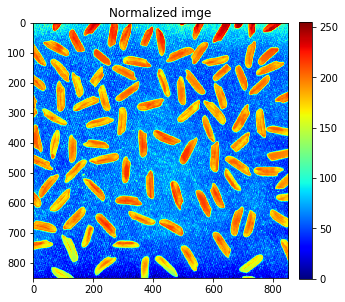

In [33]:
corrected_normalized = image_corrected - image_corrected.min()
corrected_normalized = 255 * corrected_normalized / corrected_normalized.max()

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(corrected_normalized, cmap='jet')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('Normalized imge');

#### Trying out the thresholding algorithms again:

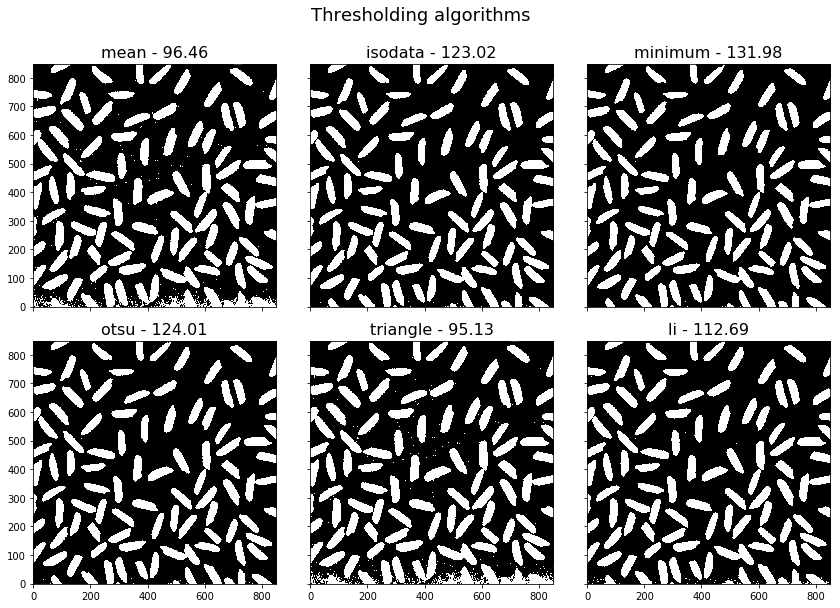

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=True, sharey=True)

for axis, algo in zip(axes.flat, 
                      # These are three algorithms we will try:
                      [threshold_mean, threshold_isodata, threshold_minimum, 
                       threshold_otsu, threshold_triangle, threshold_li]):
    
    # First calculate the threshold value
    thresh = algo(corrected_normalized)
    
    # Find all pixels whose intensity is greater than the threshold
    binary_img = corrected_normalized > thresh
    
    axis.imshow(binary_img, cmap='gray', origin='lower')
    algo_name = algo.__name__.split('_')[1]
    axis.set_title('{} - {}'.format(algo_name, np.round(thresh, 2)), fontsize=16)
    
fig.suptitle('Thresholding algorithms', fontsize=18, y=1.05)
fig.tight_layout()

### Removing the background!

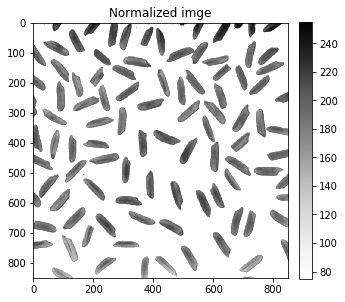

In [33]:
thresh = threshold_otsu(corrected_normalized)
background_removed_rice = corrected_normalized.copy()
background_removed_rice[corrected_normalized < thresh] = 0

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(background_removed_rice, cmap='Greys', vmin=75)
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('Normalized imge');

## [Blob detection](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html) for finding atoms:

Three popular techniques:
* Laplacian of Gaussian (LoG)
* Difference of Gaussian (DoG)
* Determinant of Hessian (DoH)

### Laplacian of Gaussian (LoG)
This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected. See skimage.feature.blob_log() for usage.

In [34]:
# Run this cell to see how to configure the parameters for blob_log
?blob_log

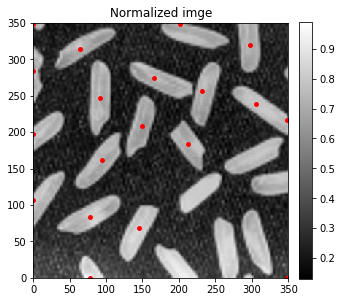

In [35]:
whitened_rice = corrected_normalized[:350, :350] * (1/256)

# Use shift+tab -><- here to find out documentation for blob_log
result = blob_log(whitened_rice, min_sigma=20, max_sigma=500, 
                  num_sigma=10, threshold=0.05)

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(whitened_rice, cmap='gray')
axis.scatter(result[:, 1], result[:, 0], s=15, c='r')
axis.set_xlim(left=0, right=whitened_rice.shape[0])
axis.set_ylim(bottom=0, top=whitened_rice.shape[1]);
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('Normalized imge');

## Exercise:
1. Can you optimize the parameters to detect all the rice above?
2. Try to use filters, LoG, and the other techniques you learnt so far to to identify atoms in the STEM image.
3. Too easy? Can you identify the larger and smaller atoms separately?

## Measuring blobs
### Label each grain seprately:

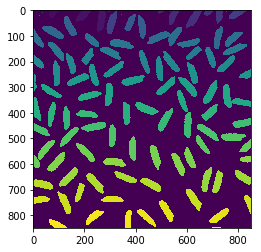

In [36]:
# First threshold
thresh = threshold_otsu(corrected_normalized)
# Then create the binary image 
grains = corrected_normalized > thresh
# Now label each of the grains separately
all_labels = measure.label(grains)

fig, axis = plt.subplots()
axis.imshow(all_labels);

### What else can we measure?

See [here](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for more information about regionprops

In [37]:
map_props = measure.regionprops(all_labels)
grain = map_props[70]
type(grain)

skimage.measure._regionprops._RegionProperties

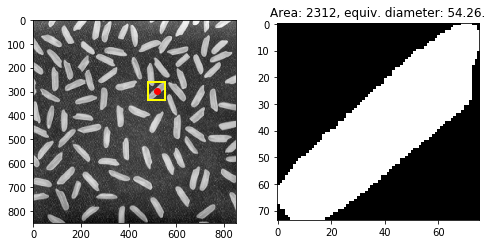

In [38]:
fig, axes = plt.subplots(ncols=2 ,figsize=(8, 4))
axes[0].imshow(corrected_normalized, cmap='gray');
# Centroid:
axes[0].scatter(grain.centroid[1],grain.centroid[0], c='red')
# Bounding box:
axes[0].add_patch(Rectangle((grain.bbox[1], grain.bbox[0]), 
                            grain.bbox[2]-grain.bbox[0], 
                            grain.bbox[3]-grain.bbox[1], fill=False,
                                         color='yellow', linewidth=2))
axes[1].imshow(grain.image, cmap='gray');
axes[1].set_title('Area: {}, equiv. diameter: {}'
                  '.'.format(grain.area, 
                             np.round(grain.equivalent_diameter,2)));

In [39]:
dir(grain)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_intensity_image',
 '_intensity_image_double',
 '_label_image',
 '_ndim',
 '_slice',
 '_transpose_moments',
 '_use_xy_warning',
 'area',
 'bbox',
 'bbox_area',
 'centroid',
 'convex_area',
 'convex_image',
 'coords',
 'eccentricity',
 'equivalent_diameter',
 'euler_number',
 'extent',
 'filled_area',
 'filled_image',
 'image',
 'inertia_tensor',
 'inertia_tensor_eigvals',
 'intensity_image',
 'label',
 'local_centroid',
 'major_axis_length',
 'max_intensity',
 'mean_intensity',
 'min_intensity',
 'minor_axis_length',
 'moments',
 'moments_central',
 'moments_hu',
 'moments_normalized',

### Visualizing the centroids of the grains

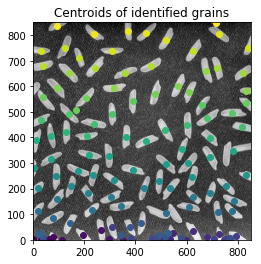

In [40]:
fig, axis = plt.subplots()
axis.imshow(corrected_normalized, cmap='gray', origin='lower');
for grain_ind, grain in enumerate(map_props):
    axis.scatter(grain.centroid[1], grain.centroid[0], 
                 color=plt.cm.viridis(int(255.0 * grain_ind / (len(map_props)-1))))
axis.set_xlim(left=0, right=corrected_normalized.shape[0])
axis.set_ylim(bottom=0, top=corrected_normalized.shape[0])
axis.set_title('Centroids of identified grains');

### Exercises:
You can see that ``skimage`` identifies too many grains, especially in the bottom of the image (first few grains identified). Can you use the properties of the measured grains to remove fake grains?